#  Sequence Classification: The IMDb Review Sentiment Classification Dataset
#### ... or very basic NLP in a nutshell

In [21]:
import os
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
sns.set_style("darkgrid")

In [2]:
def plot_cm(y_true, y_pred, classlabels=None,ax=None, xlabel='predicted class',ylabel='actual class',cmtitle='Confusion Matrix'):
    if ax is None:
        fig,ax = plt.subplots()
    conf = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf, annot=True, fmt="d",cmap=sns.color_palette("Blues"),ax=ax)
    if classlabels is not None:
        ax.set(xticklabels=classlabels)
        ax.set(yticklabels=classlabels)
    ax.set(xlabel=xlabel)
    ax.set(ylabel=ylabel)
    ax.set(title=cmtitle)

In [3]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None,monitor='val_loss', mode='min',plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

The datasets contains reviews from the International Movie Database (IMDb). Each review is labeled to be 'positive' (1) or 'negative' (0).
The reviews in the dataset are already preprocessed such that the words are already integer-coded (according to their relative freuqnecy). We use only the top-5000-words. All other words will be mapped to "unknown". If you want/need to save computation time please skip e.g. each second sample from train and test set.

In [4]:
top_words = 5000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=top_words)

__Task:__ Choose an arbitrary review from the training set and print it. Also print the length of the review.

In [5]:
rev= 4
print('Length of review %d: %d' %(rev,len(train_data[rev])))
print(train_data[rev])

Length of review 4: 147
[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626, 1400, 45, 3171, 13, 70, 79, 49, 706, 919, 13, 16, 355, 340, 355, 1696, 96, 143, 4, 22, 32, 289, 7, 61, 369, 71, 2359, 5, 13, 16, 131, 2073, 249, 114, 249, 229, 249, 20, 13, 28, 126, 110, 13, 473, 8, 569, 61, 419, 56, 429, 6, 1513, 18, 35, 534, 95, 474, 570, 5, 25, 124, 138, 88, 12, 421, 1543, 52, 725, 2, 61, 419, 11, 13, 1571, 15, 1543, 20, 11, 4, 2, 5, 296, 12, 3524, 5, 15, 421, 128, 74, 233, 334, 207, 126, 224, 12, 562, 298, 2167, 1272, 7, 2601, 5, 516, 988, 43, 8, 79, 120, 15, 595, 13, 784, 25, 3171, 18, 165, 170, 143, 19, 14, 5, 2, 6, 226, 251, 7, 61, 113]


What is your opinion? Did the peron who wrote this review like the particular movie?
... Ok here is a way to reconstruct the original words. First we need the mapping between words and integer numbers by calling the `imdb.get_word_index()` function.

__Task:__ Print the first 5 mappings!

In [6]:
word_to_id = imdb.get_word_index()

In [7]:
word_to_id = imdb.get_word_index()
for k in range(5):
    print(list(word_to_id.items())[k])

('fawn', 34701)
('tsukino', 52006)
('nunnery', 52007)
('sonja', 16816)
('vani', 63951)


Use the code provided below to recover your chosen review to words. Take care that the numbers 0,1,2 are reserved for padding, indicating the start of a sequence and for unknown words.  (_INDEX_FROM_)

In [8]:
INDEX_FROM=3
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in train_data[rev] ))
print('-----')
print('label= ' + str(train_labels[rev]))

<START> worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon <UNK> my head in i stuck that damn movie in the <UNK> and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and <UNK> a whole day of my life
-----
label= 0


You might have noticed that the reviews are of different length. This is a common and well known problem also in time-series problems (e.g. when measurements/processes are not of the same length). The good thing is that RNNs and its cousins (LSTM,GRU) can handle sequences of different length. But in the storage (GPU for example) the sequences need to have the same length. In keras we can zero-pad the sequences to the same length and then use the concept of _masking_. The recurrent layers will then ignore the values which are set to zero during all computations. 

__Task:__ Use the `pad_sequences()` function from the keras preprocessing to bring all reviews to the same length (also for the test data). The final length of the reviews will affect the computation time of the following model(s) so choose it according to the power of your machine!

In [9]:
max_review_length = 500
train_data = pad_sequences(train_data, maxlen=max_review_length)
test_data = pad_sequences(test_data, maxlen=max_review_length)

Lets check the result.

In [10]:
print(' '.join(id_to_word[id] for id in train_data[rev] ))

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

Ok. Basically it would be possible right now to feed our sequences into a recurrent model. But we will do one more thing - We will compute so called _word embeddings_. We find a transformation from positive integer indexes into dense vectors of a fixed size. The length of such an embedding vector is a parameter we can define. The output will then have one more mode - so we will have: batch_size _x_ max_review_length _x_ embedding_vector_length.

__Task:__ Extend the function below to build a model to classify the sentiment of the reviews. Use (at least one) recurrent layer (LSTM, GRU, RNN). Use the following arguments: 

In [15]:
def build_recurrent(max_review_length=250, embedding_vector_length=8):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length, mask_zero=True))
    model.add(Dropout(0.2))
    model.add(LSTM(16, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(16,activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

Now train your model. As usual we will use the early stopping callback. Training an LSTM can be very time consuming (Backprop through time), therefore we subsample when (here by 4) when training. If you have a machine of reasonable copute capavility you can use the full dataset.

In [16]:
embedding_vector_length = 32
model=build_recurrent(max_review_length=max_review_length, embedding_vector_length=embedding_vector_length)
er = EarlyStopping(verbose=1, restore_best_weights=True, monitor='val_loss',patience=5)
ch = ModelCheckpoint(filepath='lstm_weights.hdf5', verbose=0, save_best_only=True, monitor='val_loss')
history = model.fit(train_data[::4], train_labels[::4], epochs=20, initial_epoch=0, validation_split=.3, callbacks=[er,ch])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 163,425
Trainable params: 163,425
Non-trainable params: 0
________________________________________________

Lets plot the performance in each epoch.

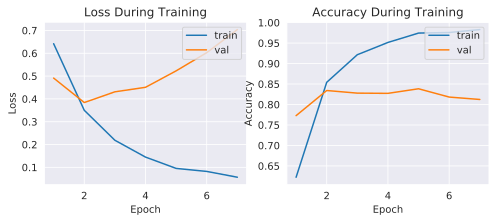

In [22]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_model_history(history, ax=ax[0])
plot_model_history(history, metric='accuracy',ax=ax[1])

What accuracy can we achive on training and test set?

In [36]:
train_labels_pred = model.predict_classes(train_data)
test_labels_pred = model.predict_classes(test_data)
print('Train accuracy (all data): ', accuracy_score(train_labels, train_labels_pred))
print('Test accuracy: ', accuracy_score(test_labels, test_labels_pred))

Train accuracy (all data):  0.84864
Test accuracy:  0.82972


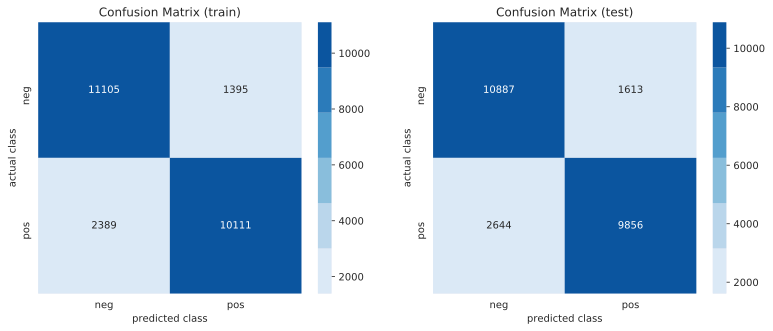

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
plot_cm(train_labels,train_labels_pred, ax=ax[0],classlabels=['neg','pos'],cmtitle='Confusion Matrix (train)')
plot_cm(test_labels,test_labels_pred, ax=ax[1],classlabels=['neg','pos'], cmtitle='Confusion Matrix (test)')

_Remark:_ In the following part we will work with a CNN which in this particular situation works much better. But we took a small LSTM to be able to run it in reasonable time on a normal machine. We can get similar/same performance with a slightly bigger LSTM and with all data. So an LSTM might not be such a bad idea to use as one could think here.
If you are interested in the topic LSTM vs CNN you can read this blogppost as a starting point: [The Fall of RNN/LSTM](https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0).

__Task:__ Build a small 1D convolutional network in the function below. Compare accuracy, complexity and training time!

In [25]:
def build_cnn(max_review_length=250, embedding_vector_length=8):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
    model.add(Dropout(0.30))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.30))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [26]:
cnn=build_cnn(max_review_length=max_review_length, embedding_vector_length=embedding_vector_length)
er = EarlyStopping(verbose=1, restore_best_weights=True, monitor='val_loss',patience=4)
history = cnn.fit(train_data, train_labels, epochs=14, initial_epoch=0, batch_size= 64, validation_split=.3, callbacks=[er])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 32)           5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 248, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7936)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7936)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

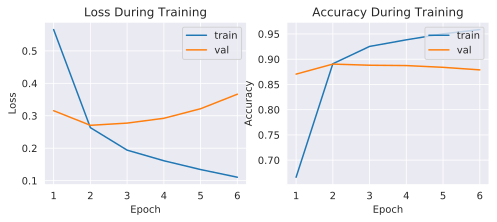

In [27]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_model_history(history, ax=ax[0])
plot_model_history(history, metric='accuracy',ax=ax[1])

In [28]:
print(cnn.evaluate(train_data, train_labels, verbose=0))
print(cnn.evaluate(test_data, test_labels, verbose=0))
train_labels_pred = cnn.predict_classes(train_data)
test_labels_pred = cnn.predict_classes(test_data)

[0.20654267072677612, 0.9228000044822693]
[0.27912637591362, 0.8828399777412415]


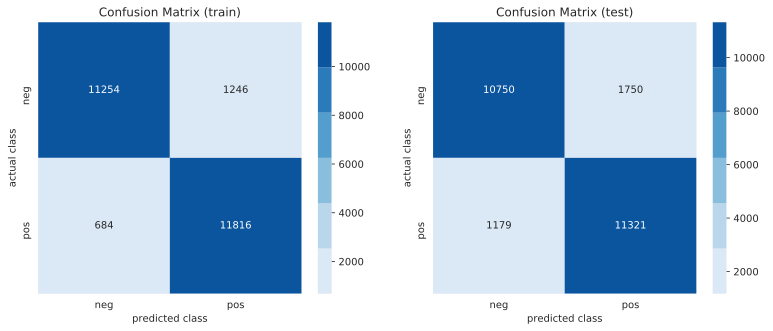

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
plot_cm(train_labels,train_labels_pred, ax=ax[0],classlabels=['neg','pos'],cmtitle='Confusion Matrix (train)')
plot_cm(test_labels,test_labels_pred, ax=ax[1],classlabels=['neg','pos'], cmtitle='Confusion Matrix (test)')

In this task we learned our very own embeddings for the particular problem. The idea behind embeddings is to map the more or less sparsely coded words into a vector space. This can for example also be done unsupervised in a way that words with similar meanings/occurence in a text are mapped close to each other. Let us check if we can find some meaning in our embeddings.
At first, we have to retrieve the weights of our embedding layer.

In [30]:
emb_weights = cnn.layers[0].get_weights()[0]
emb_weights.shape

(5000, 32)

Now we see that we have the dimensions according to the size of our vocabulary and the dimension of our embedding vectors. Next, we make a list of out top words.

In [31]:
word_list = []
for word, i in word_to_id.items():
    word_list.append(word)

Ok to do a propper scatterplot we need to transform the data to be 2D. This can be done by PCA or in a different and also very prominent way by using the so called t-SNE (t-distributed stochastic neighbor embedding). The t-SNE tries to preserve local structure (i.e. neighbourhood) in the lower dimensional space. We can use the sklearn implementation. 

In [33]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(emb_weights)
X_embedded.shape

(5000, 2)

We pick only a fraction of out words, otherwise the plot would be overfull.

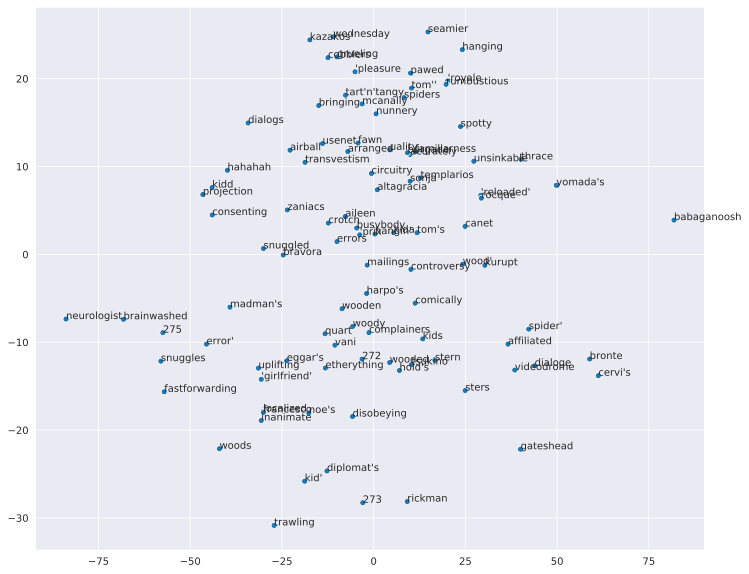

In [35]:
n_words=100
plt.figure(figsize=(12,10))
sns.scatterplot(x=X_embedded[:n_words,0], y=X_embedded[:n_words,1])
for kk,nme in enumerate(word_list[:n_words]):
     plt.annotate(nme,(X_embedded[kk,0]+.01,(X_embedded[kk,1])))